In [1]:
import numpy as np
import xgboost as xgb

from skimage import io
from sklearn.metrics import jaccard_score


import matplotlib.pyplot as plt
import PIL

In [2]:
# Increase the limit of allowed images size
PIL.Image.MAX_IMAGE_PIXELS = 10e10

In [3]:
# Set the lame names
lame = "12AG01290_26"
label = "Tumor"

In [4]:
# Load the image
img = io.imread(f'data/{lame}/results/images_aligned/PANCKm-CD8r.ome.tiff')

# Load the lebel binary mask
mask_original = io.imread(f'data/{lame}/results/masks/PANCKm-CD8r_{label}_mask.png')

In [5]:
# Load the model file
model = xgb.Booster()
model.load_model(f"models/xgboost_{label}_model.model")

# Set the model to use GPU
model.set_param({'device':'gpu'})

In [6]:
# Define the center and size of the tile
center = (50000, 50000)
size = 10000

# Take a tile from the image
img_tile = img[center[0]-size//2:center[0]+size//2,
               center[1]-size//2:center[1]+size//2]

In [7]:
# pridict the image using the model
dtest = xgb.DMatrix(img_tile.reshape(-1, 3))
prediction = model.predict(dtest)

In [18]:
# Reshape the mask to the original image size
mask_predicted = prediction.reshape(img_tile.shape[0], img_tile.shape[1]) 

# Binarize the mask using a threshold
mask_predicted = mask_predicted > 0.85

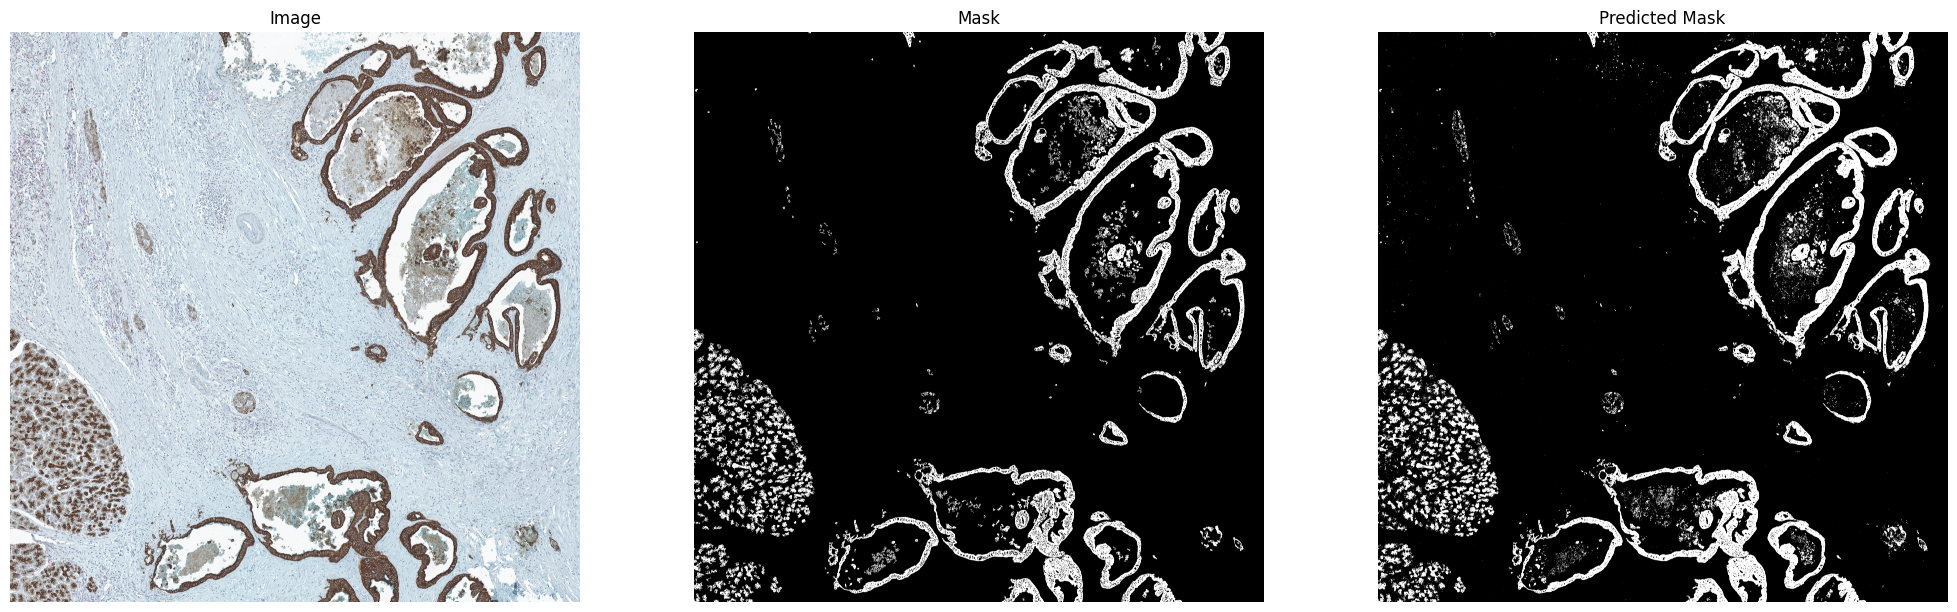

In [19]:
# Plot the mask and the predicted mask
fig, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(img[center[0]-size//2:center[0]+size//2,
                 center[1]-size//2:center[1]+size//2])
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask_original[center[0]-size//2:center[0]+size//2,
                           center[1]-size//2:center[1]+size//2], cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(mask_predicted, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')
plt.show()

In [20]:
# Compute the intersection over union
iou = jaccard_score(mask_original[center[0]-size//2:center[0]+size//2,
                                  center[1]-size//2:center[1]+size//2].flatten(),
                                  mask_predicted.flatten())

print(f"IoU: {iou:.2f}")

IoU: 0.75


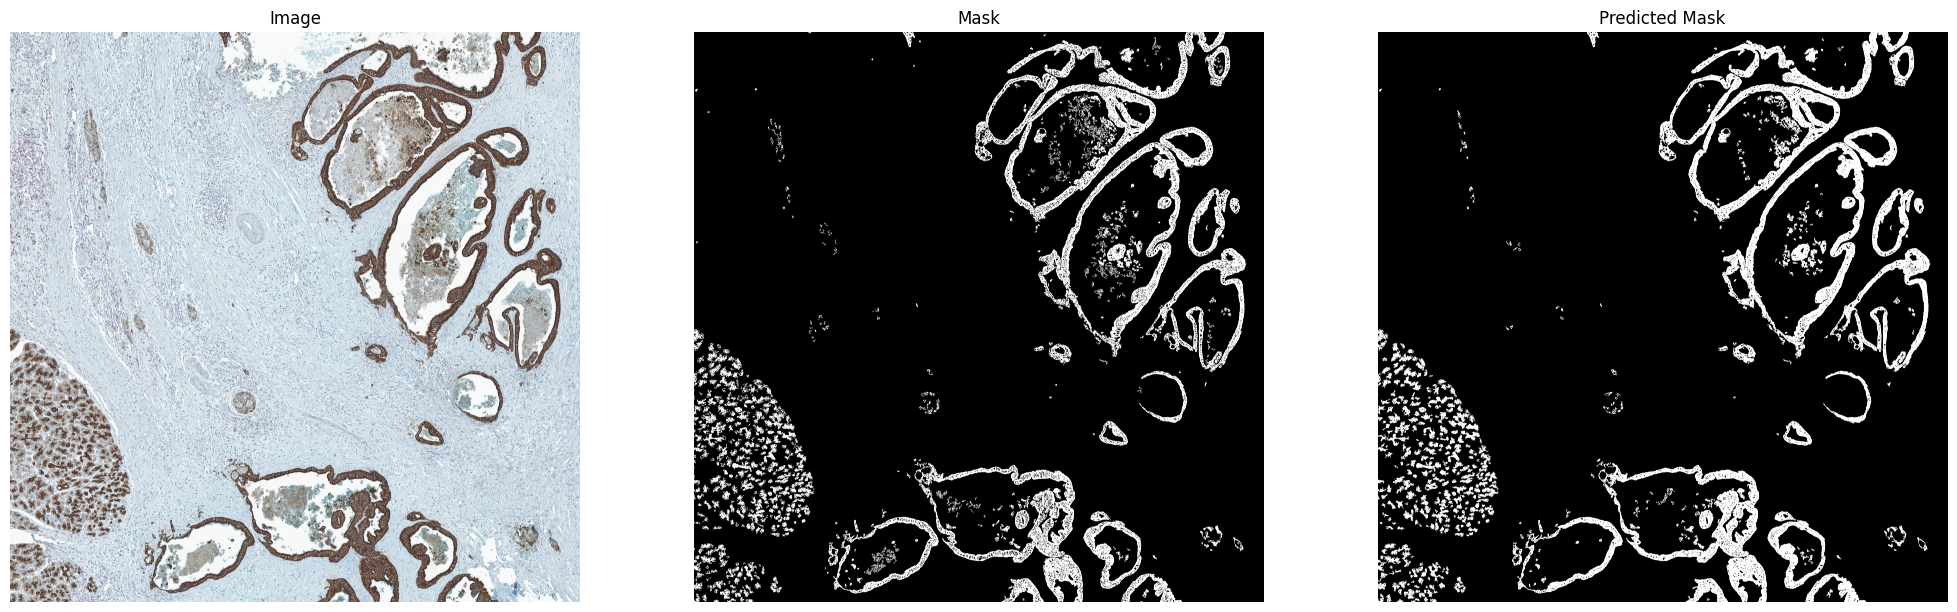

In [21]:
# Clean the mask from small objects
import skimage.morphology as morph

mask_cleaned = morph.remove_small_objects(mask_predicted, min_size=1000)

# Plot the mask and the predicted mask
fig, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(img[center[0]-size//2:center[0]+size//2,
                 center[1]-size//2:center[1]+size//2])
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask_original[center[0]-size//2:center[0]+size//2,
                            center[1]-size//2:center[1]+size//2], cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(mask_cleaned, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')
plt.show()

In [22]:
# Compute the intersection over union
iou = jaccard_score(mask_original[center[0]-size//2:center[0]+size//2,
                                  center[1]-size//2:center[1]+size//2].flatten(),
                                  mask_cleaned.flatten())

print(f"IoU: {iou:.2f}")

IoU: 0.79
